<a href="https://colab.research.google.com/github/PhamDucThinh1995/metal-nut-classification-segmentation/blob/main/metal_nut_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm
!pip install wandb
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 9.6 MB/s 
     |████████████████████████████████| 153 kB 47.5 MB/s 
     |████████████████████████████████| 181 kB 67.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3c90b808d90e1531026e0934508d222dbbf1c459a8e2a6921d42c7fa934c234e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 14.3 MB/s 
     |████████████████████████████████| 48.3 MB 1.8 MB/s 
  Attempt

In [2]:
# import the necessary packages
import torch
import os
import cv2
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import pandas as pd
import multiprocessing as mp
import timm
import torchvision.transforms.functional as VisionF
import skimage.io as io
import seaborn as sns
import wandb
import typing 
import albumentations as A

from imutils import paths
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d, MaxPool2d
from torch.nn import Module, ModuleList
from torch.nn import ReLU, BatchNorm2d
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import CenterCrop, RandomRotation, RandomVerticalFlip
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from fastai.vision import *
from fastai.callback import *
from PIL import Image
from glob import glob
from fastprogress.fastprogress import master_bar, progress_bar
from torch.autograd import Variable
from tqdm import tqdm


In [3]:
wandb.init(project="my-test-project")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# define the path to the images and masks dataset
DATASET_PATH = "/content/drive/MyDrive/metal_nut"
IMAGE_DATASET_PATH = os.path.join("/content/drive/MyDrive/metal_nut/train/good")
IMAGE_TEST_PATH = os.path.join("/content/drive/MyDrive/metal_nut/test")
MASK_DATASET_PATH = os.path.join("/content/drive/MyDrive/metal_nut/ground_truth")

PRE-PROCESSING DATA

In [6]:
def find_files(directory, file_format):
    """ 
    input = directory (path)
    input = file_format './*.png'
    outpur = list of files
    """
    files=glob(os.path.join(directory,file_format))
    return files

img_files=find_files(IMAGE_DATASET_PATH,'*.png') 

In [7]:
dirs = os.listdir(IMAGE_TEST_PATH)

vid_dirs= glob(os.path.join(IMAGE_TEST_PATH,'*'))
for i in range(len(vid_dirs)):
    vid_dirs[i] = vid_dirs[i].replace('\\', '/')

gtruth = glob(os.path.join(MASK_DATASET_PATH,'*'))
for i in range(len(gtruth)):
    gtruth[i] = gtruth[i].replace('\\', '/')

In [8]:
### Purpose: Split into "good" and "damaged" dataset for classification
metal_good=[]
metal_damaged=[]
mask_truth=[]
for i in range(len(vid_dirs)):
  if (vid_dirs[i].split('/')[-1])!='good':
    metal_damaged+=find_files(vid_dirs[i],'*.png')
  else:
    metal_good+=(find_files(IMAGE_DATASET_PATH,'*.png'))
for i in range(len(gtruth)):
  mask_truth+=find_files(gtruth[i],'*.png')

In [9]:
df_good = pd.DataFrame([])
df_good['imgs'] = metal_good
df_good['estimate'] = 'good'
df_good['tag'] = 1
df_damaged = pd.DataFrame([])
df_damaged['imgs'] = metal_damaged
df_damaged['estimate'] = 'dammaged'
df_damaged['tag'] = 0
df_=pd.concat([df_good,df_damaged],axis=0)

In [10]:
metal_damaged.sort()
mask_truth.sort()

In [11]:
df_segmentation = pd.DataFrame([])
df_segmentation['imgs'] = metal_damaged
df_segmentation['mask'] = mask_truth
df_segmentation['estimate'] = 'dammaged'
df_segmentation['tag'] = 0
df_segmentation.to_csv('./segmentation.csv',header=True,index=False)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(list(df_['imgs']), list(df_['tag']), test_size = 0.1, random_state=42,shuffle=True)

In [13]:
df_train = pd.DataFrame([])
df_train['imgs'] = X_train
df_train['target'] = y_train
df_train['is_valid'] = False
df_val = pd.DataFrame([])
df_val['imgs'] = X_val
df_val['target'] = y_val
df_val['is_valid'] = True
df_anno = pd.concat([df_train,df_val],axis=0)
df_anno.to_csv('./annotation.csv',header=True,index=False)

CLASSIFICATION IN GOOD OR DAMAGED

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [15]:
config = {}

config['size'] = 224
config['rotation_degrees']=90
config['angle_shear']=45
config['num_classes'] = 2
config['batch_size'] = 32
config['num_workers'] = 0
config['output_nodes'] = 2
config['epochs'] = 100
config['lr'] = 1e-3
# Optimizer parameters                                                                 
config['lr_step_size'] = 10              
config['lr_gamma'] = 0.8   
config['momentum'] = 0.9                             
config['weight_decay'] = 0.05           

In [16]:
df_data = pd.read_csv('./annotation.csv')
df_data.head()

,imgs,target,is_valid
0,/content/drive/MyDrive/metal_nut/train/good/04...,1,False
1,/content/drive/MyDrive/metal_nut/train/good/10...,1,False
2,/content/drive/MyDrive/metal_nut/train/good/01...,1,False
3,/content/drive/MyDrive/metal_nut/train/good/08...,1,False
4,/content/drive/MyDrive/metal_nut/test/scratch/...,0,False


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


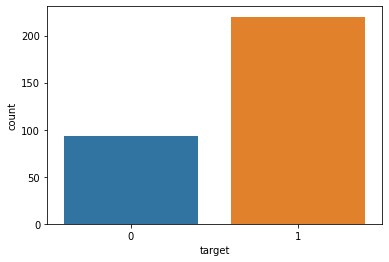

In [17]:
g = sns.countplot(df_data['target'])

In [18]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [19]:
mean = [0.485, 0.456, 0.406]                                               
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((config['size'],config['size'])),
    transforms.RandomRotation(degrees=config['rotation_degrees']),
    transforms.RandomAffine(degrees=(30, 60),shear=config['angle_shear']),
    transforms.ToTensor(),
    GaussianNoise(0.05, 0.2),
    transforms.Normalize(mean, std)])

valid_transform = transforms.Compose([
    transforms.Resize((config['size'],config['size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

class METALNUTDataset(Dataset):                                                   
    
    def __init__(self, df, transform):
        """
        df: is the dataframe annotation image and attribute
        transform: transform augmentation
        """
        self.df = df
        self.transform = transform
        self.image = list(self.df['imgs'])        
        self.target = list(self.df['target'])

    def __getitem__(self, idx):
        
        img_path = self.image[idx]
        img_arr = cv2.imread(img_path)
        img = Image.fromarray(img_arr)
        img = self.transform(img)

        target = torch.tensor(int(self.target[idx]))
        target = target.type(torch.LongTensor)

        return img, target
    
    def __len__(self):
        return len(self.df)

In [20]:
train_ds = METALNUTDataset(df=df_data[df_data['is_valid']==False] , transform = train_transform)
valid_ds = METALNUTDataset(df=df_data[df_data['is_valid']==True] , transform = valid_transform)
train_dl = DataLoader(train_ds, config['batch_size'], config['num_workers'])    
valid_dl = DataLoader(valid_ds, config['batch_size'], config['num_workers'])

In [21]:
def show_batch(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig=plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
def show(imgs):
  if not isinstance(imgs, list):
      imgs = [imgs]
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  for i, img in enumerate(imgs):
      img = img.detach()
      img = VisionF.to_pil_image(img)
      axs[0, i].imshow(np.asarray(img))
      axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

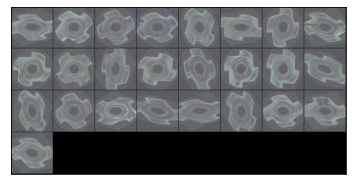

In [22]:
for x, labels in train_dl:
  img_grid = make_grid(x, normalize=True)
show(img_grid)

In [23]:
for x, y in train_dl:                                                   #WHY?
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1])


In [24]:
model = torch.nn.Sequential(timm.create_model('resnet18',pretrained=True,num_classes = config['num_classes']))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [25]:
model(x.to(device)).shape

torch.Size([32, 2])

In [26]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #TODO
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [27]:
def calculate_metrics(pred, target):
    pred = np.argmax(pred, axis=1)
#     target = np.argmax(target, axis=1)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro')
           }

In [28]:
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,                                           
                    data_loader, optimizer: torch.optim.Optimizer,
                    device: torch.device, mb):
    model.train()
    losses = []

    for samples, targets in progress_bar(data_loader, parent = mb):
        batch_size = targets.size(0)
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)  
        outputs = model(samples)                          
        loss = criterion(outputs, targets)
        loss_value = loss.item()
        losses.append(loss_value)
        optimizer.zero_grad()      
        loss.backward()
        optimizer.step()
    
    return np.mean(losses)

def evaluate(model, criterion, data_loader, device):                                                      
    model.eval()
    losses = []
    list_outputs = []
    list_targets = []
    with torch.no_grad():
        for samples, targets in progress_bar(data_loader):
            batch_size = targets.size(0)

            samples = samples.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)        
            
            outputs = model(samples)
            loss = criterion(outputs, targets)
            loss_value = loss.item()
            losses.append(loss_value)
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()
            list_outputs += list(outputs)
            list_targets += list(targets)
        metric = calculate_metrics(np.array(list_outputs), np.array(list_targets))
    return np.mean(losses), metric

In [29]:
def inference(model, data_loader, device):                                               #WHY?       giống evaluate
    model.eval()
    list_outputs = []
    list_targets = []
    list_outputs_1 = []
    list_array_max_val = []
    with torch.no_grad():
        for x,targets in progress_bar(data_loader):
            batch_size = targets.size(0)

            x1=x.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True) 
            targets = targets.type(torch.LongTensor)
            
            model.to(device)
            outputs = model(x1)
            outputs_1 = torch.nn.functional.softmax(outputs).tolist()
            targets = targets.cpu().numpy()
            array_max_val = np.amax(torch.nn.functional.softmax(outputs).cpu().numpy(), axis=1)
            outputs = np.argmax(torch.nn.functional.softmax(outputs).cpu().numpy(),axis=1)


            list_outputs_1 += list(outputs_1)
            list_outputs += list(outputs)
            list_targets += list(targets)
            list_array_max_val +=list(array_max_val)
    return list_outputs_1, list_outputs, list_targets, list_array_max_val

In [30]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, 
                            lr = config['lr'], 
                            momentum=config['momentum'], 
                            weight_decay = config['weight_decay'])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size= config['lr_step_size'],
                                               gamma=config['lr_gamma'])

# criterion = torch.nn.CrossEntropyLoss()
criterion=FocalLoss()

In [31]:
mb = master_bar(range(1, config['epochs']+1))

for epoch in mb:
    train_loss = train_one_epoch(model, criterion, train_dl, optimizer, device, mb)
    wandb.log({"train_loss": train_loss})
    lr_scheduler.step()
    
    print(f'Training epoch: {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    
    if (epoch)%2==0:
        valid_loss, valid_metric = evaluate(model, criterion, valid_dl, device)
        wandb.log({"valid_loss": valid_loss})
        print(f'\tValid Loss: {valid_loss:.3f}')
        print(f'\tMetric: {valid_metric}')

# wandb.config = {
#   "learning_rate": config['lr'],
#   "epochs": config['epochs'],
#   "batch_size": config['size'] 
# }


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 1
	Train Loss: 0.335
Training epoch: 2
	Train Loss: 0.304


	Valid Loss: 0.450
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 3
	Train Loss: 0.301
Training epoch: 4
	Train Loss: 0.294


	Valid Loss: 0.276
	Metric: {'micro/precision': 0.875, 'micro/recall': 0.875, 'micro/f1': 0.875, 'macro/precision': 0.875, 'macro/recall': 0.8272727272727273, 'macro/f1': 0.8454106280193237}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 5
	Train Loss: 0.275
Training epoch: 6
	Train Loss: 0.255


	Valid Loss: 0.301
	Metric: {'micro/precision': 0.78125, 'micro/recall': 0.78125, 'micro/f1': 0.78125, 'macro/precision': 0.7467532467532467, 'macro/recall': 0.759090909090909, 'macro/f1': 0.751937984496124}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 7
	Train Loss: 0.244
Training epoch: 8
	Train Loss: 0.243


	Valid Loss: 0.323
	Metric: {'micro/precision': 0.625, 'micro/recall': 0.625, 'micro/f1': 0.625, 'macro/precision': 0.625, 'macro/recall': 0.6454545454545455, 'macro/f1': 0.6113360323886641}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 9
	Train Loss: 0.248
Training epoch: 10
	Train Loss: 0.251


	Valid Loss: 0.318
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.6450980392156862, 'macro/recall': 0.6681818181818182, 'macro/f1': 0.6389743589743591}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 11
	Train Loss: 0.233
Training epoch: 12
	Train Loss: 0.229


	Valid Loss: 0.310
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6902834008097165, 'macro/recall': 0.7136363636363636, 'macro/f1': 0.6945917285259808}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 13
	Train Loss: 0.226
Training epoch: 14
	Train Loss: 0.229


	Valid Loss: 0.303
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6703703703703703, 'macro/recall': 0.6045454545454545, 'macro/f1': 0.6081632653061224}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 15
	Train Loss: 0.241
Training epoch: 16
	Train Loss: 0.236


	Valid Loss: 0.291
	Metric: {'micro/precision': 0.75, 'micro/recall': 0.75, 'micro/f1': 0.75, 'macro/precision': 0.8666666666666667, 'macro/recall': 0.6, 'macro/f1': 0.5897435897435896}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 17
	Train Loss: 0.232
Training epoch: 18
	Train Loss: 0.215


	Valid Loss: 0.287
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.8548387096774194, 'macro/recall': 0.55, 'macro/f1': 0.5060034305317325}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 19
	Train Loss: 0.225
Training epoch: 20
	Train Loss: 0.217


	Valid Loss: 0.285
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 21
	Train Loss: 0.225
Training epoch: 22
	Train Loss: 0.228


	Valid Loss: 0.294
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6703703703703703, 'macro/recall': 0.6045454545454545, 'macro/f1': 0.6081632653061224}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 23
	Train Loss: 0.201
Training epoch: 24
	Train Loss: 0.214


	Valid Loss: 0.296
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6153846153846154, 'macro/recall': 0.5818181818181818, 'macro/f1': 0.5833333333333333}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 25
	Train Loss: 0.214
Training epoch: 26
	Train Loss: 0.211


	Valid Loss: 0.297
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6153846153846154, 'macro/recall': 0.5818181818181818, 'macro/f1': 0.5833333333333333}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 27
	Train Loss: 0.213
Training epoch: 28
	Train Loss: 0.224


	Valid Loss: 0.300
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.5742857142857143, 'macro/recall': 0.5590909090909091, 'macro/f1': 0.5594493116395495}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 29
	Train Loss: 0.202
Training epoch: 30
	Train Loss: 0.192


	Valid Loss: 0.295
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6954022988505747, 'macro/recall': 0.5772727272727273, 'macro/f1': 0.5656108597285068}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 31
	Train Loss: 0.197
Training epoch: 32
	Train Loss: 0.192


	Valid Loss: 0.295
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6954022988505747, 'macro/recall': 0.5772727272727273, 'macro/f1': 0.5656108597285068}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 33
	Train Loss: 0.214
Training epoch: 34
	Train Loss: 0.190


	Valid Loss: 0.299
	Metric: {'micro/precision': 0.625, 'micro/recall': 0.625, 'micro/f1': 0.625, 'macro/precision': 0.5416666666666667, 'macro/recall': 0.5363636363636364, 'macro/f1': 0.536231884057971}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 35
	Train Loss: 0.197
Training epoch: 36
	Train Loss: 0.187


	Valid Loss: 0.296
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6071428571428572, 'macro/recall': 0.5545454545454546, 'macro/f1': 0.5428571428571429}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 37
	Train Loss: 0.194
Training epoch: 38
	Train Loss: 0.191


	Valid Loss: 0.295
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 39
	Train Loss: 0.174
Training epoch: 40
	Train Loss: 0.209


	Valid Loss: 0.312
	Metric: {'micro/precision': 0.59375, 'micro/recall': 0.59375, 'micro/f1': 0.59375, 'macro/precision': 0.5144927536231884, 'macro/recall': 0.5136363636363637, 'macro/f1': 0.5134502923976607}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 41
	Train Loss: 0.191
Training epoch: 42
	Train Loss: 0.190


	Valid Loss: 0.293
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6954022988505747, 'macro/recall': 0.5772727272727273, 'macro/f1': 0.5656108597285068}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 43
	Train Loss: 0.196
Training epoch: 44
	Train Loss: 0.202


	Valid Loss: 0.291
	Metric: {'micro/precision': 0.71875, 'micro/recall': 0.71875, 'micro/f1': 0.71875, 'macro/precision': 0.6954022988505747, 'macro/recall': 0.5772727272727273, 'macro/f1': 0.5656108597285068}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 45
	Train Loss: 0.188
Training epoch: 46
	Train Loss: 0.182


	Valid Loss: 0.292
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6071428571428572, 'macro/recall': 0.5545454545454546, 'macro/f1': 0.5428571428571429}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 47
	Train Loss: 0.186
Training epoch: 48
	Train Loss: 0.176


	Valid Loss: 0.292
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6, 'macro/recall': 0.5272727272727273, 'macro/f1': 0.4871794871794872}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 49
	Train Loss: 0.186
Training epoch: 50
	Train Loss: 0.173


	Valid Loss: 0.291
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.3387096774193548, 'macro/recall': 0.4772727272727273, 'macro/f1': 0.39622641509433965}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 51
	Train Loss: 0.178
Training epoch: 52
	Train Loss: 0.177


	Valid Loss: 0.293
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 53
	Train Loss: 0.206
Training epoch: 54
	Train Loss: 0.174


	Valid Loss: 0.292
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6071428571428572, 'macro/recall': 0.5545454545454546, 'macro/f1': 0.5428571428571429}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 55
	Train Loss: 0.177
Training epoch: 56
	Train Loss: 0.191


	Valid Loss: 0.291
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.3387096774193548, 'macro/recall': 0.4772727272727273, 'macro/f1': 0.39622641509433965}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 57
	Train Loss: 0.176
Training epoch: 58
	Train Loss: 0.171


	Valid Loss: 0.294
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 59
	Train Loss: 0.164
Training epoch: 60
	Train Loss: 0.188


	Valid Loss: 0.293
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.5114942528735632, 'macro/recall': 0.5045454545454545, 'macro/f1': 0.46907993966817496}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 61
	Train Loss: 0.177
Training epoch: 62
	Train Loss: 0.185


	Valid Loss: 0.291
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.6, 'macro/recall': 0.5272727272727273, 'macro/f1': 0.4871794871794872}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 63
	Train Loss: 0.164
Training epoch: 64
	Train Loss: 0.177


	Valid Loss: 0.292
	Metric: {'micro/precision': 0.65625, 'micro/recall': 0.65625, 'micro/f1': 0.65625, 'macro/precision': 0.5114942528735632, 'macro/recall': 0.5045454545454545, 'macro/f1': 0.46907993966817496}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 65
	Train Loss: 0.180
Training epoch: 66
	Train Loss: 0.177


	Valid Loss: 0.296
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 67
	Train Loss: 0.170
Training epoch: 68
	Train Loss: 0.171


	Valid Loss: 0.295
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 69
	Train Loss: 0.160
Training epoch: 70
	Train Loss: 0.182


	Valid Loss: 0.295
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 71
	Train Loss: 0.176
Training epoch: 72
	Train Loss: 0.166


	Valid Loss: 0.297
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 73
	Train Loss: 0.178
Training epoch: 74
	Train Loss: 0.167


	Valid Loss: 0.296
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 75
	Train Loss: 0.151
Training epoch: 76
	Train Loss: 0.173


	Valid Loss: 0.307
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 77
	Train Loss: 0.151
Training epoch: 78
	Train Loss: 0.166


	Valid Loss: 0.304
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 79
	Train Loss: 0.177
Training epoch: 80
	Train Loss: 0.165


	Valid Loss: 0.298
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 81
	Train Loss: 0.174
Training epoch: 82
	Train Loss: 0.169


	Valid Loss: 0.301
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 83
	Train Loss: 0.147
Training epoch: 84
	Train Loss: 0.170


	Valid Loss: 0.301
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 85
	Train Loss: 0.152
Training epoch: 86
	Train Loss: 0.162


	Valid Loss: 0.303
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 87
	Train Loss: 0.157
Training epoch: 88
	Train Loss: 0.153


	Valid Loss: 0.303
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 89
	Train Loss: 0.153
Training epoch: 90
	Train Loss: 0.145


	Valid Loss: 0.305
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 91
	Train Loss: 0.168
Training epoch: 92
	Train Loss: 0.161


	Valid Loss: 0.310
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 93
	Train Loss: 0.162
Training epoch: 94
	Train Loss: 0.161


	Valid Loss: 0.309
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 95
	Train Loss: 0.151
Training epoch: 96
	Train Loss: 0.162


	Valid Loss: 0.307
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 97
	Train Loss: 0.161
Training epoch: 98
	Train Loss: 0.181


	Valid Loss: 0.305
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training epoch: 99
	Train Loss: 0.165
Training epoch: 100
	Train Loss: 0.157


	Valid Loss: 0.307
	Metric: {'micro/precision': 0.6875, 'micro/recall': 0.6875, 'micro/f1': 0.6875, 'macro/precision': 0.34375, 'macro/recall': 0.5, 'macro/f1': 0.4074074074074074}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
df_list = pd.DataFrame([])
list_outputs_1, list_outputs, list_targets, list_array_max_val= inference(model, valid_dl, device)
df_list['list_targets']=list_targets
df_list['list_outputs']=list_outputs
df_list['max_probability']=list_array_max_val
df_list['list_outputs_1']=[np.array(item) for item in list_outputs_1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [33]:
print(classification_report(list_outputs, list_targets))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.69      0.81        32

    accuracy                           0.69        32
   macro avg       0.50      0.34      0.41        32
weighted avg       1.00      0.69      0.81        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


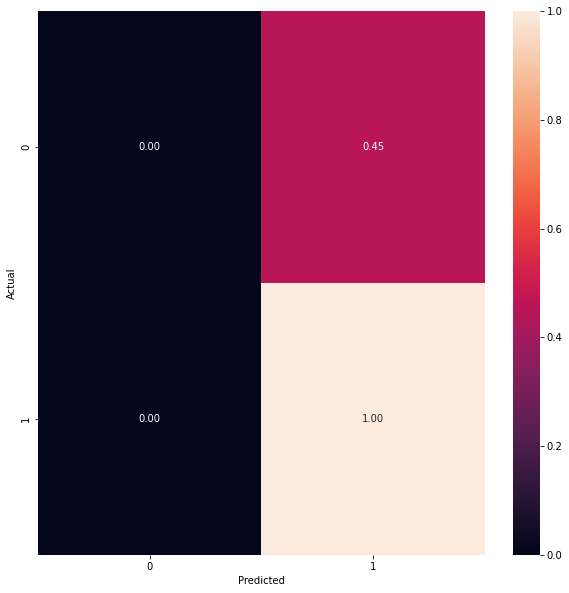

In [34]:
import seaborn as sns
C = confusion_matrix(list_targets, list_outputs)
cmn = C / C.astype('float').sum(axis=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

SEGMENTATION

In [35]:
# define the test split
VALID_SPLIT = 0.1
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
PIN_MEMORY

True

In [36]:
###UNET Training segmentation
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = config['size']
INPUT_IMAGE_HEIGHT = config['size']
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [37]:
# from locale import ABDAY_4
# mean = [0.485, 0.456, 0.406]                                               
# std = [0.229, 0.224, 0.225]

# train_transform = transforms.Compose(
#     [
#         A.Resize(config['size'], config['size']),
#         # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2,
#     ]
# )

# valid_transform = A.Compose(
#     [A.Resize(config['size'], config['size']), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
# )
# valid_transform = transforms.Compose([
#     transforms.Resize((config['size'],config['size'])),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)])

#U-Net: Training Image Segmentation Models in PyTorch
# class SegmentationDataset(Dataset):
#   def __init__(self, imagePaths, maskPaths, transforms):
#     # store the image and mask filepaths, and augmentation
#     # transforms
#     self.imagePaths = imagePaths
#     self.maskPaths = maskPaths
#     self.transforms = transforms
#   def __len__(self):
#     # return the number of total samples contained in the dataset
#     return len(self.imagePaths)
#   def __getitem__(self, idx):
#     # grab the image path from the current index
#     imagePath = self.imagePaths[idx]
#     # load the image from disk, swap its channels from BGR to RGB,
#     # and read the associated mask from disk in grayscale mode
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     img = Image.fromarray(image)

#     mask_array = cv2.imread(self.maskPaths[idx])
#     mask_array_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
#     mask = Image.fromarray(mask_array_bw)
#     # check to see if we are applying any transformations
#     if self.transforms is not None:
#       # apply the transformations to both image and its mask
#       image = self.transforms(image)
#       mask = self.transforms(mask)
#     # return a tuple of the image and its mask
#     return (image, mask)

In [38]:
class MetalDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transform = None) :
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transform = transform
        
    def __len__(self) :
        return len(self.imagePaths)
    
    def __getitem__(self, index) :

        img_path = self.imagePaths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask_array = cv2.imread(self.maskPaths[index])
        mask_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
        ## structure transform
        if self.transform:
            transformed = self.transform(image = img)
            image = transformed["image"]
            # mask = transformed["mask"]

        # labels = torch.IntTensor(labels)
        # mask_bw_ = torch.FloatTensor(np.expand_dims(mask_bw_,axis=0))
        return img, mask_bw

In [39]:
### Add by the residual connection
class Block(Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
		# store the convolution and RELU layers
    self.conv1 = Conv2d(inChannels, outChannels, 3)
    self.bn1 = BatchNorm2d(outChannels)
    self.relu = ReLU()
    self.conv2 = Conv2d(outChannels, outChannels, 3)
    self.bn2 = BatchNorm2d(outChannels)
  def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
    return self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))

In [40]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [41]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks 
    # ConvTranspose2d using for upsampling block
    # encFeatures : the list of intermediate outputs from the encoder
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks => to make sure the dimension of encFeature is equal to x
			# concatenate them with our current upsampled feature map x, along the channel dimension
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [42]:
### Encoder start with 3 channels
### Encoder double the number of channels. Decoder reduce the channels by a factor of 2 at every step
### nbClasses: This defines the number of segmentation classes where we have to classify each pixel
### retainDim: This indicates whether we want to retain the original output dimension.
### outSize: This determines the spatial dimensions of the output segmentation map. We set this to the same dimension as our input image
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16),
              nbClasses=1, retainDim=True,outSize=(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize
  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
    encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
      # return the segmentation map
    return map

In [43]:
# load the image and mask filepaths in a sorted manner
df_segmendata = pd.read_csv('./segmentation.csv')
df_segmendata.head()
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
Xseg_train, Xseg_val, yseg_train, yseg_val = train_test_split(df_segmendata['imgs'], df_segmendata['mask'],test_size=VALID_SPLIT, random_state=42)

In [44]:
# U-Net: Training Image Segmentation Models in PyTorch
class SegmentationDataset(Dataset):
  def __init__(self, imagePaths, maskPaths, transforms,mask_transform):
    # store the image and mask filepaths, and augmentation
    # transforms
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms
    self.mask_transform=mask_transform
  def __len__(self):
    # return the number of total samples contained in the dataset
    return len(self.imagePaths)
  def __getitem__(self, idx):
    # # grab the image path from the current index
    # imagePath = self.imagePaths[idx]
    # # load the image from disk, swap its channels from BGR to RGB,
    # # and read the associated mask from disk in grayscale mode
    # image = cv2.imread(imagePath)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # img = Image.fromarray(image)

    # mask_array = cv2.imread(self.maskPaths[idx])
    # mask_array_bw = cv2.threshold(mask_array, 128, 1, cv2.THRESH_BINARY)[1]
    # mask = Image.fromarray(mask_array_bw)
    # grab the image path from the current index
    imagePath = self.imagePaths[idx]
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], 0)
    mask_array_bw = cv2.threshold(mask,128, 1, cv2.THRESH_BINARY)[1]
    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.mask_transform(mask)

    # return a tuple of the image and its mask
    return (image, mask)

In [45]:
train_trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['size'],config['size'])),
        # transforms.RandomResizedCrop(config['size']),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(200), 
        transforms.ToTensor(),
        GaussianNoise(0.1, 0.2),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
mask_trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config['size'],config['size'])),
        # transforms.RandomResizedCrop(config['size']),
        # transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.5), std=(0.5)),
    ])

In [46]:
trainseg_ds = SegmentationDataset(imagePaths=list(Xseg_train), maskPaths=list(yseg_train), transforms = train_trans,mask_transform=mask_trans)
validseg_ds = SegmentationDataset(imagePaths=list(Xseg_val), maskPaths=list(yseg_val), transforms = train_trans,mask_transform=mask_trans)
trainseg_dl = DataLoader(trainseg_ds, config['batch_size'], config['num_workers'])    
validseg_dl = DataLoader(validseg_ds, config['batch_size'], config['num_workers'])

In [47]:
# aug = A.Compose([
#     # A.OneOf([
#     #     # A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
#     #     # A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
#     # ], p=1),    
#     A.VerticalFlip(p=0.5),              
#     A.RandomRotate90(p=0.5),
#     A.OneOf([
#         A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#         A.GridDistortion(p=0.5),
#         A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
#         ], p=0.8),
#     A.CLAHE(p=0.8),
#     A.RandomBrightnessContrast(p=0.8),    
#     A.RandomGamma(p=0.8)],
#     TensorV2())

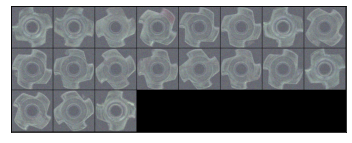

In [48]:
for x, labels in trainseg_dl:
  img_grid = make_grid(x, normalize=True)
show(img_grid)

In [49]:
labels.max()

tensor(1.)

In [50]:
labels.min()

tensor(0.)

In [51]:
x.shape

torch.Size([19, 3, 200, 200])

In [52]:
labels.shape

torch.Size([19, 1, 224, 224])

In [53]:
class FocalLoss_(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss_, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [54]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = FocalLoss_()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainseg_dl)
testSteps = len(validseg_dl) 
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [55]:
len(trainseg_dl)

3

In [56]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config['epochs'])):
  # set the model in training mode
  unet.train()
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalTestLoss = 0
  # loop over the training set
  for (i, (x, y)) in enumerate(trainseg_dl):
    # send the input to the device
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    # perform a forward pass and calculate the training loss
    pred = unet(x)
    loss = lossFunc(pred, y)

    # first, zero out any previously accumulated gradients, then
    # perform backpropagation, and then update model parameters
    opt.zero_grad()
    loss.backward()
    opt.step()
    # add the loss to the total training loss so far
    totalTrainLoss += loss
    # switch off autograd
  with torch.no_grad():
    # set the model in evaluation mode
    unet.eval()
    # loop over the validation set
    for (x, y) in validseg_dl:
      # send the input to the device
      (x, y) = (x.to(DEVICE), y.to(DEVICE))
      # make the predictions and calculate the validation loss
      pred = unet(x)
      totalTestLoss += lossFunc(pred, y)
  # calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / trainSteps
  avgTestLoss = totalTestLoss / testSteps
  wandb.log({"train_loss_unet": avgTrainLoss})
  wandb.log({"test_loss_unet": avgTestLoss})
  # update our training history
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, config['epochs']))
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 1/100 [00:11<19:05, 11.57s/it]

[INFO] EPOCH: 1/100
Train loss: 0.139614, Test loss: 0.1289


  2%|▏         | 2/100 [00:14<11:04,  6.78s/it]

[INFO] EPOCH: 2/100
Train loss: 0.127996, Test loss: 0.1260


  3%|▎         | 3/100 [00:18<08:34,  5.30s/it]

[INFO] EPOCH: 3/100
Train loss: 0.117809, Test loss: 0.1227


  4%|▍         | 4/100 [00:23<08:03,  5.03s/it]

[INFO] EPOCH: 4/100
Train loss: 0.109044, Test loss: 0.1174


  5%|▌         | 5/100 [00:26<07:10,  4.53s/it]

[INFO] EPOCH: 5/100
Train loss: 0.105503, Test loss: 0.1051


  6%|▌         | 6/100 [00:30<06:35,  4.20s/it]

[INFO] EPOCH: 6/100
Train loss: 0.092906, Test loss: 0.0974


  7%|▋         | 7/100 [00:33<06:10,  3.99s/it]

[INFO] EPOCH: 7/100
Train loss: 0.093314, Test loss: 0.0928


  8%|▊         | 8/100 [00:37<05:52,  3.84s/it]

[INFO] EPOCH: 8/100
Train loss: 0.087194, Test loss: 0.0932


  9%|▉         | 9/100 [00:40<05:39,  3.73s/it]

[INFO] EPOCH: 9/100
Train loss: 0.078898, Test loss: 0.0994


 10%|█         | 10/100 [00:44<05:27,  3.64s/it]

[INFO] EPOCH: 10/100
Train loss: 0.074214, Test loss: 0.1039


 11%|█         | 11/100 [00:47<05:18,  3.58s/it]

[INFO] EPOCH: 11/100
Train loss: 0.067990, Test loss: 0.0753


 12%|█▏        | 12/100 [00:51<05:14,  3.57s/it]

[INFO] EPOCH: 12/100
Train loss: 0.061337, Test loss: 0.0575


 13%|█▎        | 13/100 [00:54<05:10,  3.57s/it]

[INFO] EPOCH: 13/100
Train loss: 0.057723, Test loss: 0.0660


 14%|█▍        | 14/100 [00:58<05:05,  3.56s/it]

[INFO] EPOCH: 14/100
Train loss: 0.053106, Test loss: 0.0505


 15%|█▌        | 15/100 [01:01<05:01,  3.55s/it]

[INFO] EPOCH: 15/100
Train loss: 0.052842, Test loss: 0.0422


 16%|█▌        | 16/100 [01:05<04:56,  3.53s/it]

[INFO] EPOCH: 16/100
Train loss: 0.046598, Test loss: 0.0734


 17%|█▋        | 17/100 [01:09<04:53,  3.54s/it]

[INFO] EPOCH: 17/100
Train loss: 0.044057, Test loss: 0.0353


 18%|█▊        | 18/100 [01:12<04:49,  3.54s/it]

[INFO] EPOCH: 18/100
Train loss: 0.041119, Test loss: 0.0362


 19%|█▉        | 19/100 [01:16<04:47,  3.55s/it]

[INFO] EPOCH: 19/100
Train loss: 0.038344, Test loss: 0.0534


 20%|██        | 20/100 [01:19<04:40,  3.51s/it]

[INFO] EPOCH: 20/100
Train loss: 0.037112, Test loss: 0.0463


 21%|██        | 21/100 [01:23<04:39,  3.54s/it]

[INFO] EPOCH: 21/100
Train loss: 0.034843, Test loss: 0.0312


 22%|██▏       | 22/100 [01:26<04:36,  3.54s/it]

[INFO] EPOCH: 22/100
Train loss: 0.033019, Test loss: 0.0316


 23%|██▎       | 23/100 [01:30<04:33,  3.55s/it]

[INFO] EPOCH: 23/100
Train loss: 0.029924, Test loss: 0.0290


 24%|██▍       | 24/100 [01:33<04:30,  3.56s/it]

[INFO] EPOCH: 24/100
Train loss: 0.028304, Test loss: 0.0281


 25%|██▌       | 25/100 [01:37<04:25,  3.54s/it]

[INFO] EPOCH: 25/100
Train loss: 0.026580, Test loss: 0.0280


 26%|██▌       | 26/100 [01:40<04:22,  3.55s/it]

[INFO] EPOCH: 26/100
Train loss: 0.025287, Test loss: 0.0277


 27%|██▋       | 27/100 [01:44<04:17,  3.52s/it]

[INFO] EPOCH: 27/100
Train loss: 0.023024, Test loss: 0.0255


 28%|██▊       | 28/100 [01:47<04:13,  3.52s/it]

[INFO] EPOCH: 28/100
Train loss: 0.022018, Test loss: 0.0210


 29%|██▉       | 29/100 [01:51<04:10,  3.52s/it]

[INFO] EPOCH: 29/100
Train loss: 0.021413, Test loss: 0.0212


 30%|███       | 30/100 [01:55<04:14,  3.64s/it]

[INFO] EPOCH: 30/100
Train loss: 0.019793, Test loss: 0.0196


 31%|███       | 31/100 [01:59<04:21,  3.79s/it]

[INFO] EPOCH: 31/100
Train loss: 0.019081, Test loss: 0.0177


 32%|███▏      | 32/100 [02:02<04:12,  3.71s/it]

[INFO] EPOCH: 32/100
Train loss: 0.018146, Test loss: 0.0165


 33%|███▎      | 33/100 [02:06<04:04,  3.64s/it]

[INFO] EPOCH: 33/100
Train loss: 0.017631, Test loss: 0.0149


 34%|███▍      | 34/100 [02:10<03:58,  3.61s/it]

[INFO] EPOCH: 34/100
Train loss: 0.016159, Test loss: 0.0165


 35%|███▌      | 35/100 [02:13<03:52,  3.58s/it]

[INFO] EPOCH: 35/100
Train loss: 0.016075, Test loss: 0.0157


 36%|███▌      | 36/100 [02:17<03:48,  3.57s/it]

[INFO] EPOCH: 36/100
Train loss: 0.015559, Test loss: 0.0148


 37%|███▋      | 37/100 [02:20<03:43,  3.55s/it]

[INFO] EPOCH: 37/100
Train loss: 0.014837, Test loss: 0.0162


 38%|███▊      | 38/100 [02:24<03:40,  3.55s/it]

[INFO] EPOCH: 38/100
Train loss: 0.014077, Test loss: 0.0123


 39%|███▉      | 39/100 [02:27<03:37,  3.56s/it]

[INFO] EPOCH: 39/100
Train loss: 0.013578, Test loss: 0.0119


 40%|████      | 40/100 [02:31<03:32,  3.55s/it]

[INFO] EPOCH: 40/100
Train loss: 0.012591, Test loss: 0.0118


 41%|████      | 41/100 [02:34<03:29,  3.55s/it]

[INFO] EPOCH: 41/100
Train loss: 0.012226, Test loss: 0.0125


 42%|████▏     | 42/100 [02:38<03:25,  3.55s/it]

[INFO] EPOCH: 42/100
Train loss: 0.011891, Test loss: 0.0110


 43%|████▎     | 43/100 [02:41<03:22,  3.55s/it]

[INFO] EPOCH: 43/100
Train loss: 0.011414, Test loss: 0.0122


 44%|████▍     | 44/100 [02:45<03:18,  3.54s/it]

[INFO] EPOCH: 44/100
Train loss: 0.011046, Test loss: 0.0102


 45%|████▌     | 45/100 [02:48<03:12,  3.50s/it]

[INFO] EPOCH: 45/100
Train loss: 0.010579, Test loss: 0.0098


 46%|████▌     | 46/100 [02:52<03:09,  3.51s/it]

[INFO] EPOCH: 46/100
Train loss: 0.010753, Test loss: 0.0101


 47%|████▋     | 47/100 [02:55<03:06,  3.52s/it]

[INFO] EPOCH: 47/100
Train loss: 0.010125, Test loss: 0.0098


 48%|████▊     | 48/100 [02:59<03:03,  3.53s/it]

[INFO] EPOCH: 48/100
Train loss: 0.009614, Test loss: 0.0096


 49%|████▉     | 49/100 [03:02<02:59,  3.53s/it]

[INFO] EPOCH: 49/100
Train loss: 0.009846, Test loss: 0.0164


 50%|█████     | 50/100 [03:06<02:56,  3.52s/it]

[INFO] EPOCH: 50/100
Train loss: 0.009890, Test loss: 0.0101


 51%|█████     | 51/100 [03:10<02:52,  3.53s/it]

[INFO] EPOCH: 51/100
Train loss: 0.009556, Test loss: 0.0093


 52%|█████▏    | 52/100 [03:13<02:49,  3.53s/it]

[INFO] EPOCH: 52/100
Train loss: 0.008897, Test loss: 0.0408


 53%|█████▎    | 53/100 [03:17<02:45,  3.53s/it]

[INFO] EPOCH: 53/100
Train loss: 0.008760, Test loss: 0.0085


 54%|█████▍    | 54/100 [03:20<02:42,  3.53s/it]

[INFO] EPOCH: 54/100
Train loss: 0.008549, Test loss: 0.0070


 55%|█████▌    | 55/100 [03:23<02:36,  3.48s/it]

[INFO] EPOCH: 55/100
Train loss: 0.007997, Test loss: 0.0072


 56%|█████▌    | 56/100 [03:27<02:33,  3.50s/it]

[INFO] EPOCH: 56/100
Train loss: 0.007975, Test loss: 0.0075


 57%|█████▋    | 57/100 [03:31<02:37,  3.66s/it]

[INFO] EPOCH: 57/100
Train loss: 0.007614, Test loss: 0.0073


 58%|█████▊    | 58/100 [03:35<02:40,  3.81s/it]

[INFO] EPOCH: 58/100
Train loss: 0.007015, Test loss: 0.0067


 59%|█████▉    | 59/100 [03:39<02:32,  3.72s/it]

[INFO] EPOCH: 59/100
Train loss: 0.007442, Test loss: 0.0070


 60%|██████    | 60/100 [03:42<02:26,  3.66s/it]

[INFO] EPOCH: 60/100
Train loss: 0.007062, Test loss: 0.0068


 61%|██████    | 61/100 [03:46<02:21,  3.62s/it]

[INFO] EPOCH: 61/100
Train loss: 0.006928, Test loss: 0.0065


 62%|██████▏   | 62/100 [03:49<02:16,  3.59s/it]

[INFO] EPOCH: 62/100
Train loss: 0.006632, Test loss: 0.0066


 63%|██████▎   | 63/100 [03:53<02:12,  3.58s/it]

[INFO] EPOCH: 63/100
Train loss: 0.006427, Test loss: 0.0058


 64%|██████▍   | 64/100 [03:56<02:07,  3.55s/it]

[INFO] EPOCH: 64/100
Train loss: 0.006344, Test loss: 0.0062


 65%|██████▌   | 65/100 [04:00<02:03,  3.54s/it]

[INFO] EPOCH: 65/100
Train loss: 0.006354, Test loss: 0.0058


 66%|██████▌   | 66/100 [04:03<02:00,  3.53s/it]

[INFO] EPOCH: 66/100
Train loss: 0.005889, Test loss: 0.0054


 67%|██████▋   | 67/100 [04:07<01:56,  3.52s/it]

[INFO] EPOCH: 67/100
Train loss: 0.005758, Test loss: 0.0053


 68%|██████▊   | 68/100 [04:10<01:52,  3.52s/it]

[INFO] EPOCH: 68/100
Train loss: 0.005477, Test loss: 0.0054


 69%|██████▉   | 69/100 [04:14<01:48,  3.52s/it]

[INFO] EPOCH: 69/100
Train loss: 0.006000, Test loss: 0.0061


 70%|███████   | 70/100 [04:17<01:45,  3.51s/it]

[INFO] EPOCH: 70/100
Train loss: 0.005581, Test loss: 0.0057


 71%|███████   | 71/100 [04:21<01:41,  3.50s/it]

[INFO] EPOCH: 71/100
Train loss: 0.005408, Test loss: 0.0057


 72%|███████▏  | 72/100 [04:24<01:37,  3.48s/it]

[INFO] EPOCH: 72/100
Train loss: 0.005287, Test loss: 0.0053


 73%|███████▎  | 73/100 [04:28<01:34,  3.49s/it]

[INFO] EPOCH: 73/100
Train loss: 0.005204, Test loss: 0.0051


 74%|███████▍  | 74/100 [04:31<01:30,  3.50s/it]

[INFO] EPOCH: 74/100
Train loss: 0.005068, Test loss: 0.0049


 75%|███████▌  | 75/100 [04:35<01:27,  3.50s/it]

[INFO] EPOCH: 75/100
Train loss: 0.004839, Test loss: 0.0053


 76%|███████▌  | 76/100 [04:38<01:23,  3.49s/it]

[INFO] EPOCH: 76/100
Train loss: 0.004827, Test loss: 0.0055


 77%|███████▋  | 77/100 [04:42<01:20,  3.50s/it]

[INFO] EPOCH: 77/100
Train loss: 0.004754, Test loss: 0.0047


 78%|███████▊  | 78/100 [04:45<01:16,  3.47s/it]

[INFO] EPOCH: 78/100
Train loss: 0.004569, Test loss: 0.0044


 79%|███████▉  | 79/100 [04:49<01:13,  3.49s/it]

[INFO] EPOCH: 79/100
Train loss: 0.004500, Test loss: 0.0058


 80%|████████  | 80/100 [04:52<01:09,  3.50s/it]

[INFO] EPOCH: 80/100
Train loss: 0.004737, Test loss: 0.0052


 81%|████████  | 81/100 [04:56<01:06,  3.51s/it]

[INFO] EPOCH: 81/100
Train loss: 0.004393, Test loss: 0.0046


 82%|████████▏ | 82/100 [04:59<01:03,  3.51s/it]

[INFO] EPOCH: 82/100
Train loss: 0.004348, Test loss: 0.0048


 83%|████████▎ | 83/100 [05:03<00:59,  3.51s/it]

[INFO] EPOCH: 83/100
Train loss: 0.004457, Test loss: 0.0051


 84%|████████▍ | 84/100 [05:07<01:01,  3.84s/it]

[INFO] EPOCH: 84/100
Train loss: 0.004059, Test loss: 0.0049


 85%|████████▌ | 85/100 [05:11<00:56,  3.77s/it]

[INFO] EPOCH: 85/100
Train loss: 0.004164, Test loss: 0.0050


 86%|████████▌ | 86/100 [05:15<00:51,  3.69s/it]

[INFO] EPOCH: 86/100
Train loss: 0.004001, Test loss: 0.0065


 87%|████████▋ | 87/100 [05:18<00:47,  3.64s/it]

[INFO] EPOCH: 87/100
Train loss: 0.003979, Test loss: 0.0048


 88%|████████▊ | 88/100 [05:22<00:43,  3.61s/it]

[INFO] EPOCH: 88/100
Train loss: 0.003881, Test loss: 0.0043


 89%|████████▉ | 89/100 [05:25<00:39,  3.55s/it]

[INFO] EPOCH: 89/100
Train loss: 0.003967, Test loss: 0.0035


 90%|█████████ | 90/100 [05:28<00:35,  3.53s/it]

[INFO] EPOCH: 90/100
Train loss: 0.003637, Test loss: 0.0041


 91%|█████████ | 91/100 [05:32<00:31,  3.53s/it]

[INFO] EPOCH: 91/100
Train loss: 0.003723, Test loss: 0.0040


 92%|█████████▏| 92/100 [05:36<00:28,  3.53s/it]

[INFO] EPOCH: 92/100
Train loss: 0.003763, Test loss: 0.0048


 93%|█████████▎| 93/100 [05:39<00:24,  3.48s/it]

[INFO] EPOCH: 93/100
Train loss: 0.003640, Test loss: 0.0044


 94%|█████████▍| 94/100 [05:42<00:20,  3.50s/it]

[INFO] EPOCH: 94/100
Train loss: 0.003753, Test loss: 0.0047


 95%|█████████▌| 95/100 [05:46<00:17,  3.49s/it]

[INFO] EPOCH: 95/100
Train loss: 0.003600, Test loss: 0.0057


 96%|█████████▌| 96/100 [05:49<00:13,  3.49s/it]

[INFO] EPOCH: 96/100
Train loss: 0.003483, Test loss: 0.0050


 97%|█████████▋| 97/100 [05:53<00:10,  3.51s/it]

[INFO] EPOCH: 97/100
Train loss: 0.003555, Test loss: 0.0041


 98%|█████████▊| 98/100 [05:56<00:06,  3.48s/it]

[INFO] EPOCH: 98/100
Train loss: 0.003388, Test loss: 0.0053


 99%|█████████▉| 99/100 [06:00<00:03,  3.49s/it]

[INFO] EPOCH: 99/100
Train loss: 0.003532, Test loss: 0.0038


100%|██████████| 100/100 [06:03<00:00,  3.64s/it]

[INFO] EPOCH: 100/100
Train loss: 0.003451, Test loss: 0.0056
[INFO] total time taken to train the model: 363.93s


In [57]:
pred.shape

torch.Size([10, 1, 224, 224])

In [58]:
y.shape

torch.Size([10, 1, 224, 224])

In [59]:
break

SyntaxError: ignored

In [60]:
def acc(input, target):
    """
    segmentation accuracy
    """
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def dice(input, targs):#->Rank0Tensor:
    """
    DICE score is the F1-score for the segmentation problems. 
    """
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.squeeze(1).view(n,-1)
    intersect = (input*targs).float().sum()
    union = (input+targs).float().sum()
    return 2. * intersect / union
    
def iou(input, targs):#->Rank0Tensor:
    """
    Intersection over Union
    """
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.squeeze(1).view(n,-1)
    intersect = (input*targs).float().sum()
    union = (input+targs).float().sum()
    return intersect / (union-intersect+1.0)

In [61]:
iou(pred,y)

tensor(0., device='cuda:0')